In [1]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 652.23 GB


In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os
# from deepgo.utils import Ontology


In [3]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [4]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [5]:
tokenizer.get_vocab_size()


544998

In [6]:
import json
with open("/home/toibazd/Most_frequent_IPs.json", "r") as f:
    ips = json.load(f)

sorted_dict = sorted(ips.items(), key=lambda x: x[1], reverse=True)
most_frequent_ips = [item[0] for item in sorted_dict[0:200]]


In [7]:
print("Number of items in most_frequent_ips list: ", len(most_frequent_ips))

Number of items in most_frequent_ips list:  200


In [8]:
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import csv
from tqdm.auto import tqdm
import numpy as np


ip_to_go = defaultdict(list)
data_dict = defaultdict(list)
enc = MultiLabelBinarizer()

# go = Ontology('data/go.obo')

new_tsv_filename = "/home/toibazd/Family_IPs_with_GO.tsv"


with open(new_tsv_filename, "r") as new_tsvfile:
    reader = csv.reader(new_tsvfile, delimiter="\t")
    next(reader)
    for row in tqdm(reader):
        ip = row[0]  # Assuming the IP is in the first column
        go_terms = row[6]  # Assuming the GO terms are in the second column

        # Add IP and corresponding GO terms to data_dict
        ip_to_go[ip]+= go_terms.split(',')



0it [00:00, ?it/s]

In [9]:

with open("/home/toibazd/Prot2IP_GO_filtered_MF.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])
        

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in most_frequent_ips and ip_to_go[ip]:
                for GO in ip_to_go[ip]:
                    data_dict[key].append(GO)
#                     data_dict[key].extend(list(go.get_ancestors(GO)))

0it [00:00, ?it/s]

In [10]:
all_values = [value for values in data_dict.values() for value in values]

# Convert the list into a set to remove duplicates
unique_go = set(all_values)

print("Number of unique GO classes considered:", len(unique_go))

Number of unique GO classes considered: 269


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()

one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print("Number of proteins that are one_hot_encoded", len(one_hot_encoded_dict.keys()))

Number of proteins that are one_hot_encoded 39936


In [12]:
# import os
# import random
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor

# directory = '/ibex/user/toibazd/InterPro_annotated_genomes_training/'
# one_hot_encoded_sentences = {}

# sentence_length = 40
# sentences_per_IP = 200

# # Set random seed for reproducibility
# random.seed(42)

# # Randomly choose 1000 files with seed 42
# selected_files = os.listdir(directory)


# # Define a function to process a file
# def process_file(filename, IP):
#     sentences = []

#     filepath = os.path.join(directory, filename)

#     with open(filepath, 'r') as file:
#         content = file.read()
#         words = content.strip().split()

#         # Check if the key is in the file
#         for i in range(19, len(words)-20):
#             # Shuffle the indices of the words containing the key
#             if IP in data_dict[words[i]]:
#                 if len(words) - i >= 21:
#                     sentence = " ".join(words[i - 19:i + sentence_length - 19])
#                     assert len(sentence.split()) == 40, "The length of the split sentence is not equal to 40."
#                     sentences.append(sentence)
#     return sentences


# # Iterate over keys
# for IP in tqdm(unique_go):
#     one_hot_encoded_sentences[IP] = []
#     sentences_count = 0

#     # Use ThreadPoolExecutor for concurrent processing
#     with ThreadPoolExecutor(max_workers=4) as executor:
#         futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
#         for future in futures:
#             sentences = future.result()
#             one_hot_encoded_sentences[IP].extend(sentences)
#             sentences_count += len(sentences)
#             if sentences_count >= sentences_per_IP:
#                 break

#     # Break if the required number of sentences per key is reached


In [13]:
# import json

# with open('BERT_DNN_senteces_with_GO.json', 'w') as f:
#     json.dump(one_hot_encoded_sentences, f)

In [14]:
with open('Research_Exp2_GO/BERT_DNN_senteces_with_GO_200.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [15]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}


In [16]:
matching_string = one_hot_encoded_sentences.values()


In [17]:
matching_string = [item for sublist in matching_string for item in sublist]
print("Number of all sentences extracted using unique_go: ", len(matching_string))

Number of all sentences extracted using unique_go:  81206


In [18]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final_context5/"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-04-03 14:19:17,943] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final_context5/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [19]:
print(len(one_hot_encoded[1]))

269


In [20]:
batch_size = 128 # Define your batch size

embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 5, :]
#     relevant_hidden_states = torch.mean(hidden_states[:, 1:-1, :], dim=1)

    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        labels.append(one_hot_encoded_dict[indicator])

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


  0%|          | 0/635 [00:00<?, ?it/s]

In [21]:
def calc_pos_weight(targets):
    """
    Calculate the pos_weight parameter for BCEWithLogitsLoss for multilabel classification.

    Args:
        targets (tensor): Binary tensor of shape (num_samples, num_classes) representing target labels.

    Returns:
        pos_weight (tensor): Tensor of shape (num_classes,) containing the pos_weight for each class.
    """
    num_classes = targets.size(1)
    pos_counts = targets.sum(dim=0)  # Count of positive samples for each class
    neg_counts = targets.size(0) - pos_counts  # Count of negative samples for each class

    # Calculate class weights
    pos_weight = neg_counts / pos_counts
    pos_weight[pos_counts == 0] = 1.0  # Avoid division by zero for classes with no positive samples

    return torch.as_tensor(pos_weight, dtype=torch.float)

In [22]:
# def calculate_pos_weights(class_counts):
#     pos_weights = np.ones_like(class_counts)
    
#     neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
#     for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
#         pos_weights[cdx] = neg_count / (pos_count + 1e-5)

#     return torch.as_tensor(pos_weights, dtype=torch.float)


# class_counts = np.array(labels).sum(axis=0)

# print(class_counts)

pos_weights = calc_pos_weight(torch.tensor(labels))

/tmp/ipykernel_352106/988310125.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  pos_weights = calc_pos_weight(torch.tensor(labels))


In [23]:
import random


# Zip the lists together
combined = list(zip(embeddings, labels))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list
embeddings, labels = zip(*combined)

In [24]:
model.to("cpu")
torch.cuda.empty_cache()

In [25]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = len(unique_go)
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [26]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels

# Define optimizer and loss function
optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.05)
criterion = torch.nn.BCEWithLogitsLoss()

In [27]:
import numpy as np

num_epochs = 10
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        batch_labels_tensor = batch_labels_tensor.squeeze()

        
        outputs = clf_model(batch_embeddings_tensor)

        
        loss = criterion(outputs, batch_labels_tensor)

        
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")


Epoch 1/10:


Training Batches: 0it [00:00, ?it/s]

0.10402885938522789
Epoch 2/10:


Training Batches: 0it [00:00, ?it/s]

0.06561611565575177
Epoch 3/10:


Training Batches: 0it [00:00, ?it/s]

0.06219500038884113
Epoch 4/10:


Training Batches: 0it [00:00, ?it/s]

0.060884560222910875
Epoch 5/10:


Training Batches: 0it [00:00, ?it/s]

0.059291340349237456
Epoch 6/10:


Training Batches: 0it [00:00, ?it/s]

0.05833318904477135
Epoch 7/10:


Training Batches: 0it [00:00, ?it/s]

0.05822921333015163
Epoch 8/10:


Training Batches: 0it [00:00, ?it/s]

0.05809794161538932
Epoch 9/10:


Training Batches: 0it [00:00, ?it/s]

0.058013771507060816
Epoch 10/10:


Training Batches: 0it [00:00, ?it/s]

0.05794590701464523
Training finished.


In [28]:
# directory = '/ibex/user/toibazd/InterPro_annotated_genomes_for_testing/'
# one_hot_encoded_sentences_2 = {}

# sentence_length = 40
# sentence_per_IP = 50
# selected_files = os.listdir(directory)


# # Iterate over keys
# for IP in tqdm(unique_go):
#     one_hot_encoded_sentences_2[IP] = []
#     sentences_count=0
    
#     # Iterate over selected files
#     for filename in selected_files:
#         filepath = os.path.join(directory, filename)

#         with open(filepath, 'r') as file:
#             content = file.read()
#             words = content.strip().split()

#             # Check if the key is in the file
#             for i in range(19, len(words)-20):
#                 # Shuffle the indices of the words containing the key
#                 if IP in data_dict[words[i]]:
#                     if len(words) - i >= 21:
#                         sentence = " ".join(words[i - 19:i + sentence_length - 19])
#                         one_hot_encoded_sentences_2[IP].append(sentence)
#                         sentences_count += 1
#                         if sentences_count>=sentence_per_IP:
#                             break
#         if sentences_count>=sentence_per_IP:
#             break
#     print(sentences_count)
            

In [29]:
# import json

# with open('BERT_DNN_senteces_with_GO_test.json', 'w') as f:
#     json.dump(one_hot_encoded_sentences_2, f)

In [30]:
with open('Research_Exp2_GO/BERT_DNN_senteces_with_GO_test_200.json', "r") as f:
    test_sentences = json.load(f)

In [31]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

269

In [32]:
matching_string = test_sentences.values()
len(matching_string)

269

In [33]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

21490

In [34]:
batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 5, :]
#     relevant_hidden_states = torch.mean(hidden_states[:, 1:-1, :], dim=1)
    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/168 [00:00<?, ?it/s]

In [35]:
model.to("cpu")
torch.cuda.empty_cache()

In [36]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=269, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [37]:
generator = data_generator(test_embeddings, test_labels, batch_size)


from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

all_labels = []
all_probs = []



for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [38]:

# Concatenate predictions and labels across all batches
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [39]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("GO-centric AUC score:  ")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

GO-centric AUC score:  
0 :  0.512205813408345
1 :  0.5373751700312308
2 :  0.9189810487001775
3 :  0.603242191448499
4 :  0.9052053838807095
5 :  0.5195269082011208
6 :  0.7790871871815653
7 :  0.7848059309095848
8 :  0.6010607760635811
9 :  0.7683507566361063
10 :  0.6688919302364457
11 :  0.45114082204577294
12 :  0.7837691967850848
13 :  0.9550891600187705
14 :  0.9595059469146379
15 :  0.9758785284121094
16 :  0.6947886297376094
17 :  0.7617142799638874
18 :  0.8122970215131772
19 :  0.4894405619049685
20 :  0.9489142483970059
21 :  0.4204063571665622
22 :  0.4759892051708871
23 :  0.7832627885808441
24 :  0.7253613248578119
25 :  0.6846346108766994
26 :  0.5885794325816853
27 :  0.36958633497974425
28 :  0.5292435294117648
29 :  0.8904919224408948
30 :  0.9532672519981847
31 :  0.8534170588235295
32 :  0.7402174592752399
33 :  0.9326833673487818
34 :  0.657957534693286
35 :  0.7806446319737459
36 :  0.6499391282292837
37 :  0.815647948481558
38 :  0.9495335783660506
39 :  0.53283

In [40]:
print("Number of AUC scores: ", len(auc_scores))

Number of AUC scores:  269


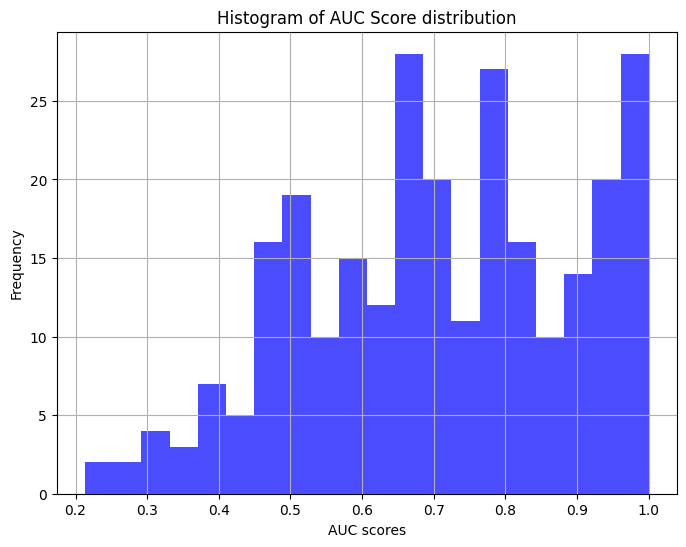

In [41]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))  # Increase the size of the plot
plt.hist(auc_scores, bins=20, color='b', alpha=0.7)  # Plot histogram with 10 bins, blue color, and transparency
plt.xlabel('AUC scores')  # Label x-axis
plt.ylabel('Frequency')  # Label y-axis
plt.title('Histogram of AUC Score distribution')  # Add a title
plt.grid(True)  # Add grid lines

plt.show()

In [42]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print("*** micro AUC score for Exp2***: ",metrics.auc(fpr, tpr))
print("*** macro AUC score for Exp2***: ",np.nanmean(auc_scores))

*** micro AUC score for Exp2***:  0.8564830366703853
*** macro AUC score for Exp2***:  0.7056881731048273


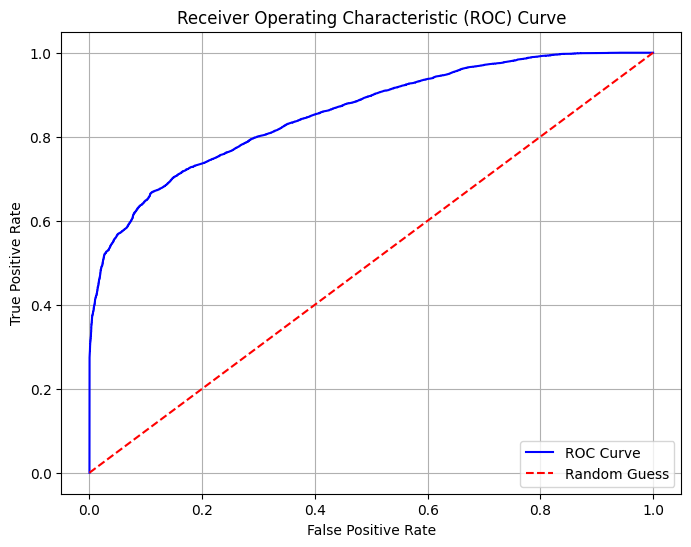

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [44]:
all_probs[0]

array([0.00834441, 0.0095645 , 0.00512317, 0.00950672, 0.0106894 ,
       0.0176849 , 0.07512265, 0.00756893, 0.00693275, 0.02147565,
       0.03821492, 0.00374927, 0.01560649, 0.00346434, 0.00625367,
       0.00810062, 0.00451789, 0.00748024, 0.00960496, 0.00902459,
       0.01484212, 0.00588781, 0.00811395, 0.02277502, 0.00595333,
       0.0057428 , 0.00933619, 0.00854392, 0.0151725 , 0.00397161,
       0.00561681, 0.00617506, 0.00690452, 0.00600322, 0.01606318,
       0.00704178, 0.01593093, 0.00345637, 0.01261697, 0.00279758,
       0.00827666, 0.00551004, 0.00912875, 0.01069552, 0.00277393,
       0.01227333, 0.00291434, 0.00382835, 0.00024827, 0.000263  ,
       0.00563217, 0.00821064, 0.00813329, 0.00872649, 0.00403606,
       0.0180825 , 0.0104462 , 0.00601786, 0.00534458, 0.01600405,
       0.00741886, 0.00715223, 0.00595198, 0.01531431, 0.12447044,
       0.0364364 , 0.0173726 , 0.01574305, 0.0108683 , 0.01220882,
       0.01463274, 0.01007613, 0.00764569, 0.00770112, 0.00907

In [45]:
import numpy as np
from sklearn.metrics import fbeta_score
from tqdm import tqdm

def calculate_Fmax_score_per_class(y_true, y_pred_probs, beta=1):
    """
    Calculate the Fmax score for each class in multilabel classification.
    
    Parameters:
        y_true (numpy array): True labels with shape (n_samples, n_classes).
        y_pred_probs (numpy array): Predicted probabilities with shape (n_samples, n_classes).
        beta (float): Weight for precision in harmonic mean. 
                      For beta < 1, more weight is assigned to recall. For beta > 1, more weight is assigned to precision.
        
    Returns:
        Fmax_scores (numpy array): Fmax score for each class.
    """
    Fmax_scores = []
    for i in tqdm(range(y_true.shape[1])):  # Iterate over each class
        y_true_class = y_true[:, i].flatten()
        y_pred_probs_class = y_pred_probs[:, i]
        
        thresholds = np.arange(0, 1.005, 0.005)  # Thresholds for converting probabilities to binary predictions

        Fmax_class = 0
        for threshold in thresholds:
            y_pred_class = (y_pred_probs_class >= threshold).astype(int)
            F_score_class = fbeta_score(y_true_class, y_pred_class, beta=beta)
            if F_score_class > Fmax_class:
                Fmax_class = F_score_class
                
        Fmax_scores.append(Fmax_class)
    
    return np.array(Fmax_scores)

# Example usage:
# Assuming all_labels and all_probs are numpy arrays containing true labels and predicted probabilities, respectively
# all_labels.shape = (n_samples, n_classes), all_probs.shape = (n_samples, n_classes)
# beta is the weight for precision in the harmonic mean

Fmax_scores_per_class = calculate_Fmax_score_per_class(all_labels, all_probs, beta=1)
print("Fmax Scores per Class:", Fmax_scores_per_class)


100%|██████████| 269/269 [03:59<00:00,  1.13it/s]

Fmax Scores per Class: [0.0198906  0.02426323 0.65429234 0.02048511 0.73286052 0.09589041
 0.48506982 0.07954184 0.01335799 0.31961259 0.09774292 0.00741771
 0.13815188 0.25273923 0.94049734 0.33268608 0.01346633 0.04874613
 0.03191011 0.02457757 0.17353579 0.01303685 0.01046151 0.50570962
 0.01942556 0.02239485 0.02127535 0.01444727 0.03787677 0.64556962
 0.24627451 0.12645231 0.0217518  0.22939068 0.11655874 0.03612903
 0.10966057 0.05303933 0.78115183 0.00741771 0.01963672 0.01942421
 0.01807399 0.05769563 0.03074195 0.22137405 0.96580027 0.01888083
 1.         1.         0.99334221 0.11605124 0.33507171 0.01961385
 0.01220979 0.21880907 0.02186429 0.9125377  0.05762474 0.07188542
 0.0345379  0.55498282 0.66509434 0.08734365 0.50638223 0.28866868
 0.15454545 0.16354816 0.04685623 0.24369748 0.0341962  0.10407632
 0.17989418 0.1761658  0.01764476 0.0198195  0.96580027 0.69348128
 0.99334221 0.12520064 0.92814371 0.90823328 0.0738204  0.02791752
 0.0248062  0.24468085 0.87629293 0.017

In [46]:
enc.classes_[1]

'GO:0000166'

In [47]:
np.mean(Fmax_scores_per_class)

0.2135296035318961

In [50]:
for i in range(len(auc_scores)):
    print(enc.classes_[i]," : ",auc_scores[i]," : ",Fmax_scores_per_class[i])

GO:0000105  :  0.512205813408345  :  0.019890601690701143
GO:0000166  :  0.5373751700312308  :  0.024263233190271818
GO:0000179  :  0.9189810487001775  :  0.654292343387471
GO:0000271  :  0.603242191448499  :  0.020485114525296864
GO:0000287  :  0.9052053838807095  :  0.7328605200945626
GO:0001522  :  0.5195269082011208  :  0.0958904109589041
GO:0003677  :  0.7790871871815653  :  0.4850698174006445
GO:0003678  :  0.7848059309095848  :  0.07954183900731784
GO:0003684  :  0.6010607760635811  :  0.013357994245787094
GO:0003700  :  0.7683507566361063  :  0.3196125907990315
GO:0003723  :  0.6688919302364457  :  0.09774292272379495
GO:0003729  :  0.45114082204577294  :  0.007417709782104775
GO:0003735  :  0.7837691967850848  :  0.13815187557182068
GO:0003746  :  0.9550891600187705  :  0.2527392257121987
GO:0003824  :  0.9595059469146379  :  0.9404973357015985
GO:0003842  :  0.9758785284121094  :  0.3326860841423948
GO:0003855  :  0.6947886297376094  :  0.013466334164588529
GO:0003871  :  0.7